In [1]:
import pickle
import shap
import tensorflow as tf
import numpy as np
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


c:\Users\adri\Desktop\sepsis_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load LSTM

In [2]:
with open('sauvegarde/shap_values/lstm_shap.pkl', 'rb') as f:
	lstm_shap_values_all = pickle.load(f)

lstm_model = Sequential([
		InputLayer(input_shape=(6, 35)),
		LSTM(128, return_sequences=True),
		Dropout(0.25),
		LSTM(64),
		Dropout(0.25),
		Dense(128, activation='relu'),
		Dropout(0.25),
		Dense(1, activation='sigmoid')
	])
lstm_model.load_weights('sauvegarde/models/lstm_model.keras')

c:\Users\adri\Desktop\sepsis_prediction\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


# Load CNN

In [39]:
with open('sauvegarde/shap_values/cnn_shap.pkl', 'rb') as f:
	cnn_shap_values_all = pickle.load(f)

cnn_model = Sequential([
		Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(6, 35, 1)),
		MaxPooling2D(pool_size=(2, 2)),
		Dropout(0.25),

		Conv2D(64, (3, 3), activation='relu', padding='same'),
		MaxPooling2D(pool_size=(2, 2)),
		Dropout(0.25),

		Flatten(),
		Dense(128, activation='relu'),
		Dropout(0.5),
		Dense(1, activation='sigmoid')
	])
cnn_model.load_weights('sauvegarde/models/cnn_model.keras')

c:\Users\adri\Desktop\sepsis_prediction\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
cnn_shap_values_all.shape

(200, 6, 35, 1, 1)

# Load XGBoost

In [4]:
import xgboost as xgb

In [5]:
with open('sauvegarde/shap_values/xgboost_shap.pkl', 'rb') as f:
	xgb_shap_values_all = pickle.load(f)

xgb_model = xgb.XGBClassifier()
xgb_model.load_model('sauvegarde/models/xgboost_model.json') # had to downgrade scikit-learn to 1.5.2 to load the model, otherwise tags error https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags

# Visu

In [6]:
def extract_sequences(test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6):
	"""
	Prépare les données d'entraînement et de test pour l'extraction de séquences
	"""
	# column will_have_sepsis is dropped earlier in the notebook, so no attempt is made here.
	# Sélectionner les colonnes de caractéristiques
	feature_cols = [col for col in train_df.columns if col not in exclude_columns]

	return extract_sequences_and_labels(
		test_df, id_column, time_column, feature_cols, label_column, sequence_length
	)

In [7]:
data = pd.read_csv('data/df_12H_imputed_with_knn.csv')
display_basic_info(data)
train_df, test_df = split_train_test_data_v2(data)

# Pour chaque patient ayant 'will_have_sepsis' à 1, ne garder que les observations où 'SepsisLabel' est à 0
sepsis_train_df = train_df[(train_df['will_have_sepsis'] == 1) & (train_df['SepsisLabel'] == 1)]
non_sepsis_train_df = train_df[train_df['will_have_sepsis'] == 0]
df_train_balanced = pd.concat([non_sepsis_train_df, sepsis_train_df])

sepsis_test_df = test_df[(test_df['will_have_sepsis'] == 1) & (test_df['SepsisLabel'] == 0)]
non_sepsis_test_df = test_df[test_df['will_have_sepsis'] == 0]
df_test_balanced = pd.concat([non_sepsis_test_df, sepsis_test_df])

# Pour les patients ayant 'will_have_sepsis' à 1, mettre 'SepsisLabel' à 1
df_test_balanced.loc[df_test_balanced['will_have_sepsis'] == 1, 'SepsisLabel'] = 1

df_train_balanced.drop(columns='will_have_sepsis', inplace=True)
df_test_balanced.drop(columns='will_have_sepsis', inplace=True)

X_train = df_train_balanced.drop(columns='SepsisLabel')
y_train = df_train_balanced['SepsisLabel']

X_test = df_test_balanced.drop(columns='SepsisLabel')
y_test = df_test_balanced['SepsisLabel']

X_train.drop(columns='Hour', inplace=True)
X_test.drop(columns='Hour', inplace=True)

X_train.drop(columns='Patient_ID', inplace=True)
X_test.drop(columns='Patient_ID', inplace=True)

normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

original_sequences, _ = extract_sequences(test_df, exclude_columns=['Patient_ID', 'Hour', 'Sepsispredicted','SepsisLabel'], label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)



features = [col for col in train_df.columns if col not in ['Patient_ID', 'Hour', 'SepsisLabel', 'will_have_sepsis']]

Shape of the DataFrame: (52536, 39)

Number of unique patients: 4378

SepsisLabel class counts:
 SepsisLabel
0.0    39402
1.0    13134
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2189
1.0    2189
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

c:\Users\adri\Desktop\sepsis_prediction\functions_and_imports.py:565: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=drop_column, inplace=True)
c:\Users\adri\Desktop\sepsis_prediction\functions_and_imports.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=drop_column, inplace=True)


## Violins

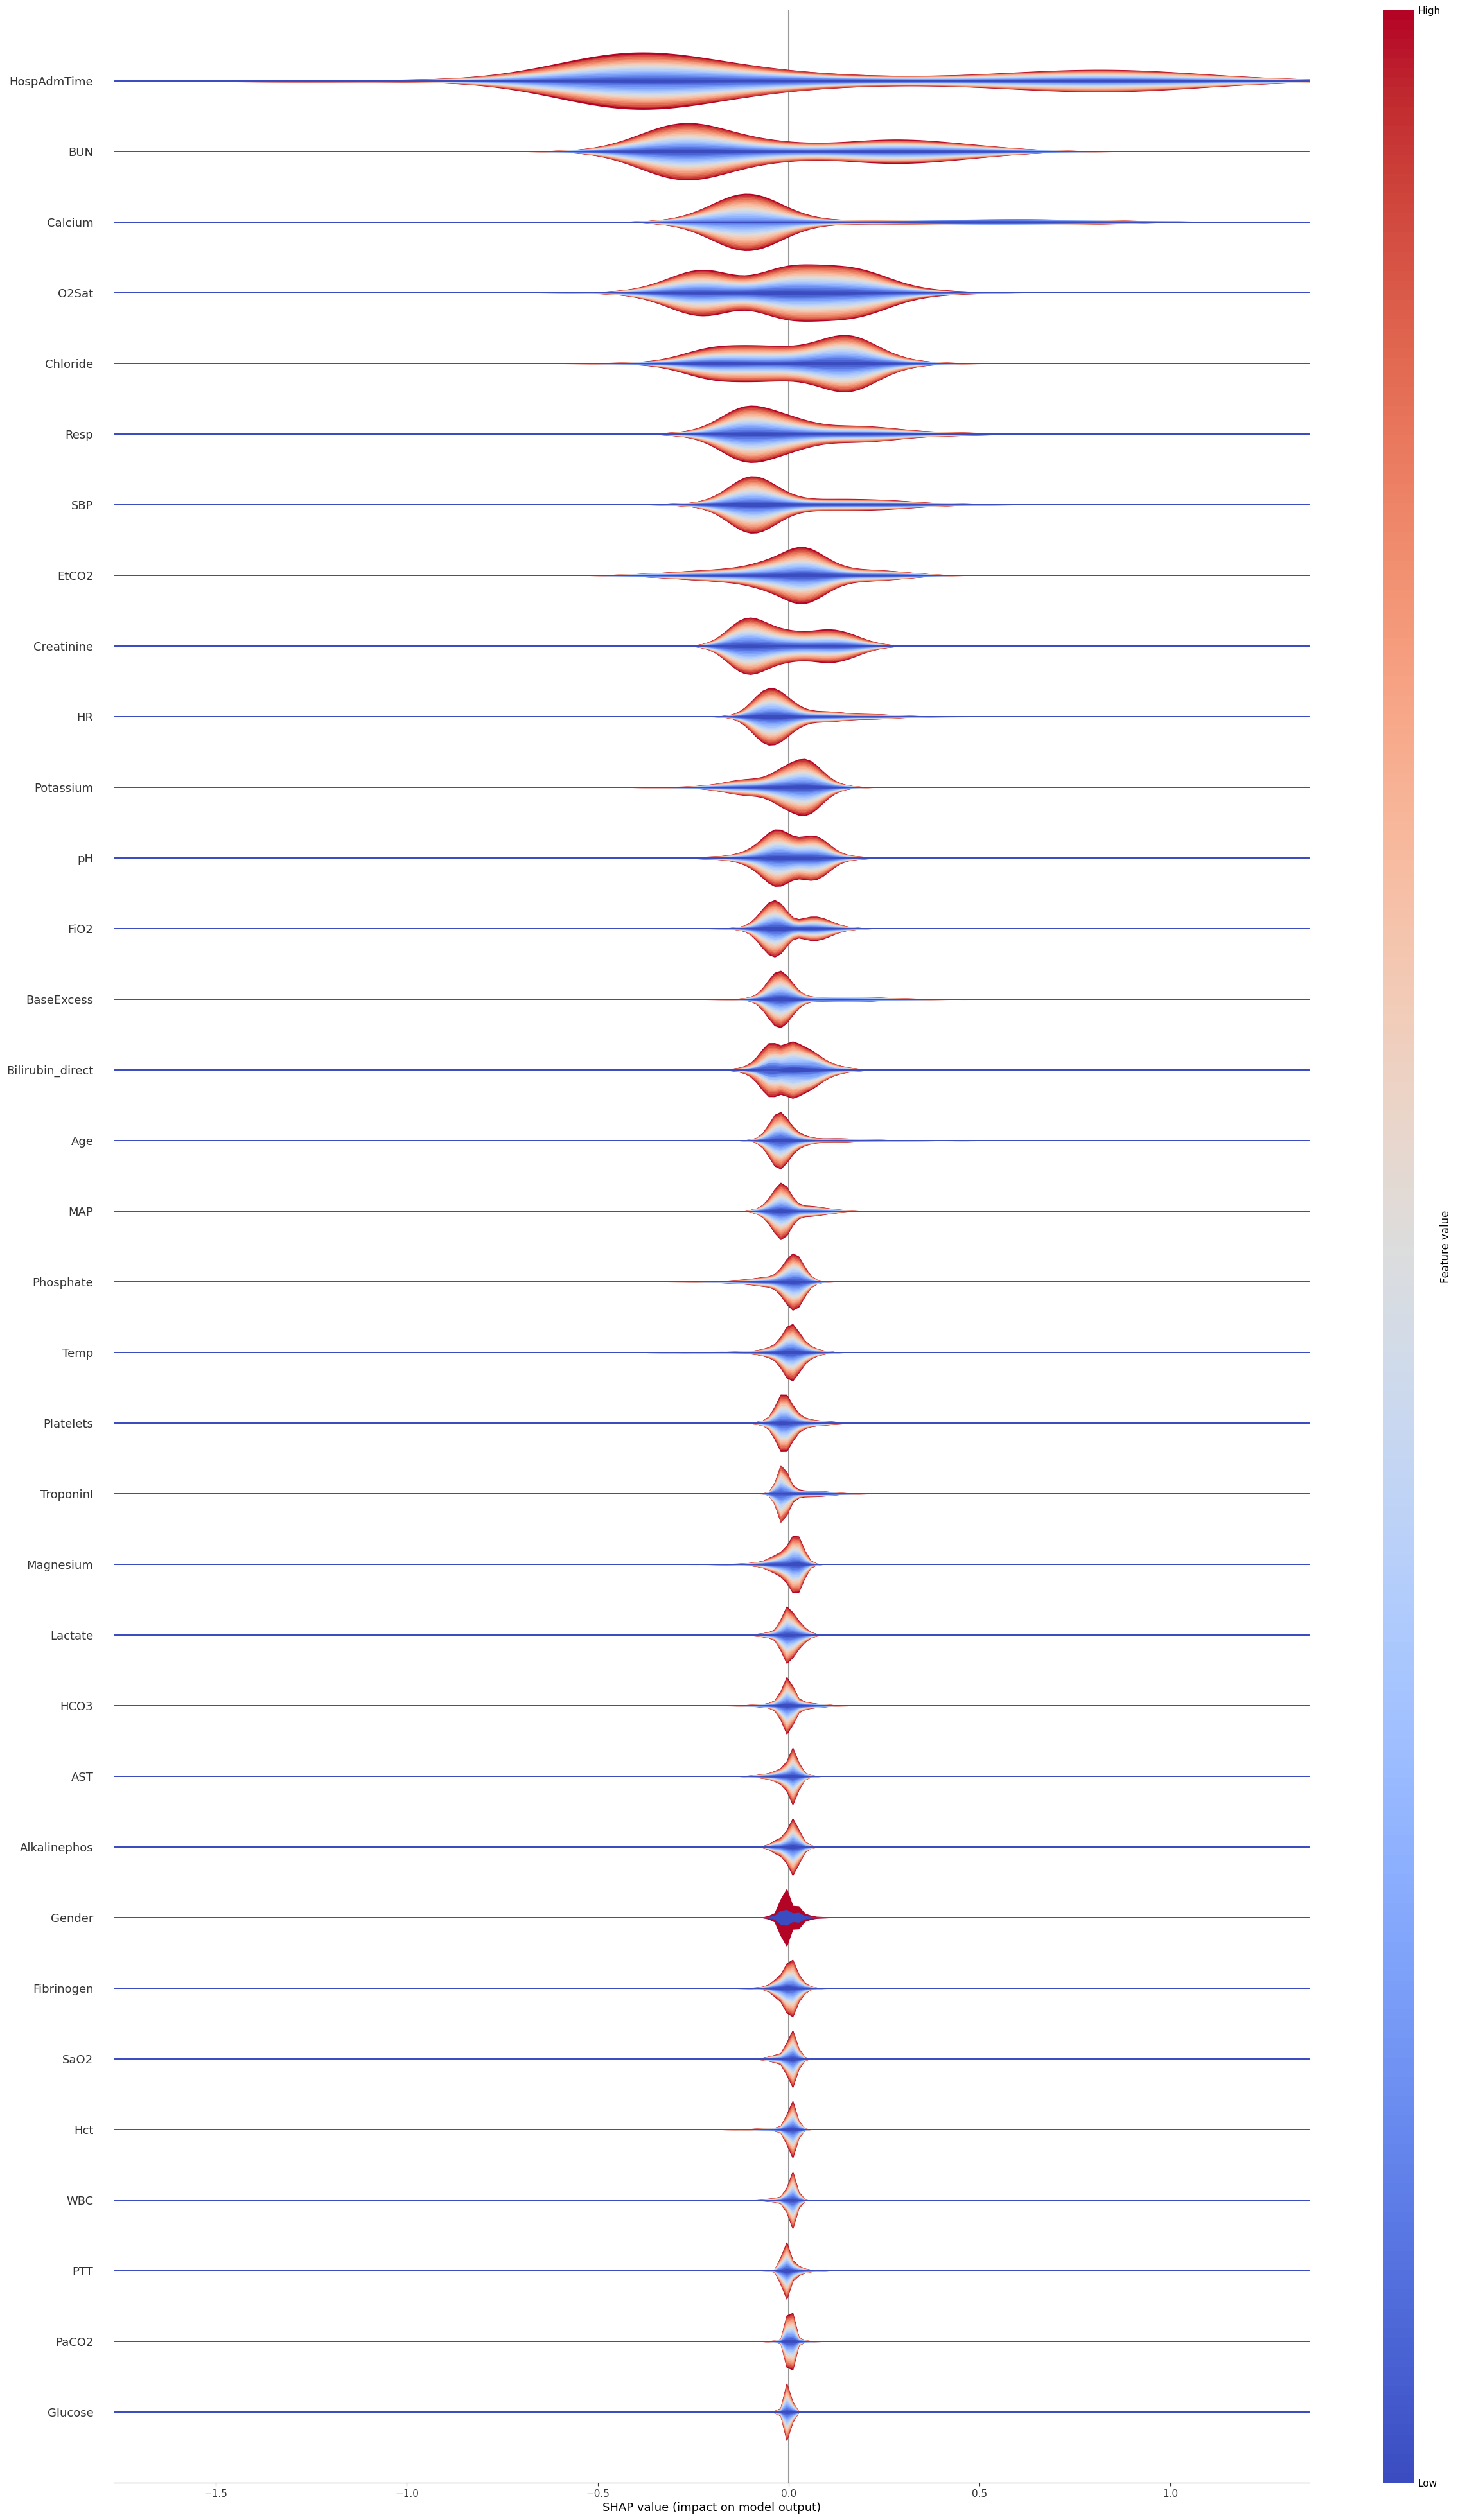

In [8]:
shap.plots.violin(xgb_shap_values_all, features=X_test[:xgb_shap_values_all.shape[0]], feature_names=features, max_display=-1, plot_type="layered_violin", plot_size=(30, 50))

In [9]:
import matplotlib.patheffects as path_effects
import cmcrameri.cm as cmc

def draw_patient_pred(data_array, text_array, prediction, auto_scale=True, max_color_scale=0.13, text_color="black", outline_text_color=None, cmap="bwr", threshold=0.7):
	if auto_scale:
		# Calculate the absolute max value in data_array to set symmetric color limits
		abs_max = max(abs(data_array.min()), abs(data_array.max()))
		vmin = -abs_max
		vmax = abs_max
	elif max_color_scale:
		# If max_color_scale is provided, use these values for the color limits
		vmin = -max_color_scale
		vmax = max_color_scale
	else:
		# Fallback to default behavior if neither auto_scale nor max_color_scale are specified
		abs_max = max(abs(data_array.min()), abs(data_array.max()))
		vmin = -abs_max
		vmax = abs_max

	plt.figure(figsize=(70, 6))  # Adjust the figure size as needed

	plt.title(f"Predicted sepsis: {prediction >= threshold} ({prediction})", fontsize=38)
	ax = sns.heatmap(data_array, annot=text_array, xticklabels=features, fmt=".2f",
					 annot_kws={"color": text_color, "fontsize": 22}, cmap=cmap , cbar=True,
					 cbar_kws={"shrink": 1.5, "aspect": 10, "label": "shap value (feature impact on sepsis prediction)"},
					 vmin=vmin, vmax=vmax)  # Set symmetric color limits based on abs max if auto_scale is True

	# Adjust the size of the color bar label for better readability
	ax.figure.axes[-1].yaxis.label.set_size(20)

	# outline values text
	if outline_text_color is not None:
		for text in ax.texts:  # `ax.texts` contains all annotations
			text.set_path_effects([
				path_effects.Stroke(linewidth=2, foreground=cmap),
				path_effects.Normal()  # Normal text appearance
			])

	ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=24)
	ax.xaxis.set_ticks_position("top")  # Place x-ticks on top
	ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

	plt.show()


In [10]:
X_test_arr = X_test.values
trueLabels = y_test.values
xgb_predictions = xgb_model.predict(X_test)

In [11]:
X_test_arr.shape

(7824, 35)

In [12]:
for i in range(len(X_test_arr)):
	if X_test_arr[i][34] == -73.39:
		print(i, X_test_arr[i])

24 [ 97.5   99.    34.94  98.3   69.    48.3   21.25  23.2   -3.    21.
   0.5    7.33  43.    97.6   26.4   33.    55.4    7.9   98.     0.6
   1.32 152.     1.2    1.6    4.1    3.8    5.28  38.4   27.8    2.8
 472.   455.    83.42   0.   -73.39]
25 [ 94.     97.5    36.392  90.5    42.     42.5    21.25   22.4    -3.
  21.      0.5     7.33   43.2    97.6    20.8    33.     62.4     7.36
  98.      0.92    1.32  125.      1.2     1.6     4.4     3.8     5.28
  38.4    31.94    2.8   472.    264.8    83.42    0.    -73.39 ]
26 [ 93.    96.    35.5  109.    75.    55.    27.    35.5   -1.8   20.6
   0.48   7.34  45.8   97.4   20.8   37.2   62.4    7.36 102.4    1.12
   1.5  126.4    1.2    1.94   4.4    3.98   5.28  31.74  32.56  11.68
 398.4  330.2   83.42   0.   -73.39]
27 [ 94.     97.     36.354 108.     71.     50.     29.     35.5    -1.8
  20.8     0.48    7.34   45.8    97.6    20.8    35.6    62.4     7.36
 101.4     1.12    1.32  118.8     1.02    1.84    4.4     4.      5.2

In [18]:
explained_data_length = 500
# Choose a subset of the validation data to explain
data_to_explain = normalize_sequences_test[:explained_data_length]
lstm_predictions = np.array([e[0] for e in lstm_model.predict(data_to_explain)])
cnn_predictions = np.array([e[0] for e in cnn_model.predict(data_to_explain)])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [24]:
print(cnn_shap_values_all.shape, lstm_shap_values_all.shape, xgb_shap_values_all.shape)
print(cnn_predictions.shape, lstm_predictions.shape, xgb_predictions.shape)

(200, 6, 35) (200, 6, 35) (5256, 35)
(500,) (500,) (7824,)


In [35]:
lstm_shap_values_all.dtype
cnn_shap_values_all.dtype

dtype('O')

LSTM: Patient 27, sepsis label: False


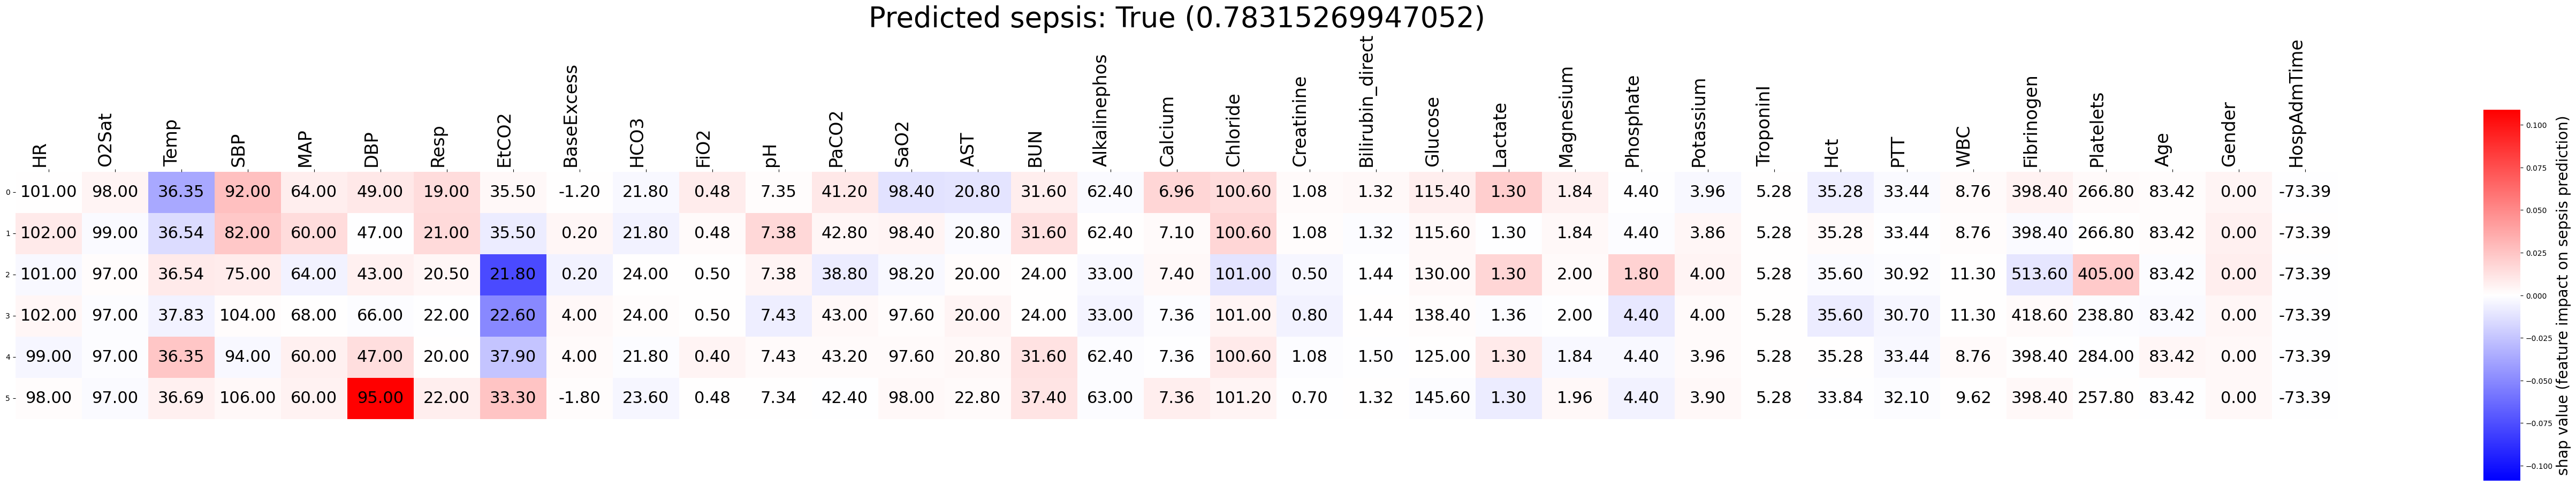

XGBoost: Patient 5, lines 30 to 35, sepsis labels: [0. 0. 0. 0. 0. 0.]


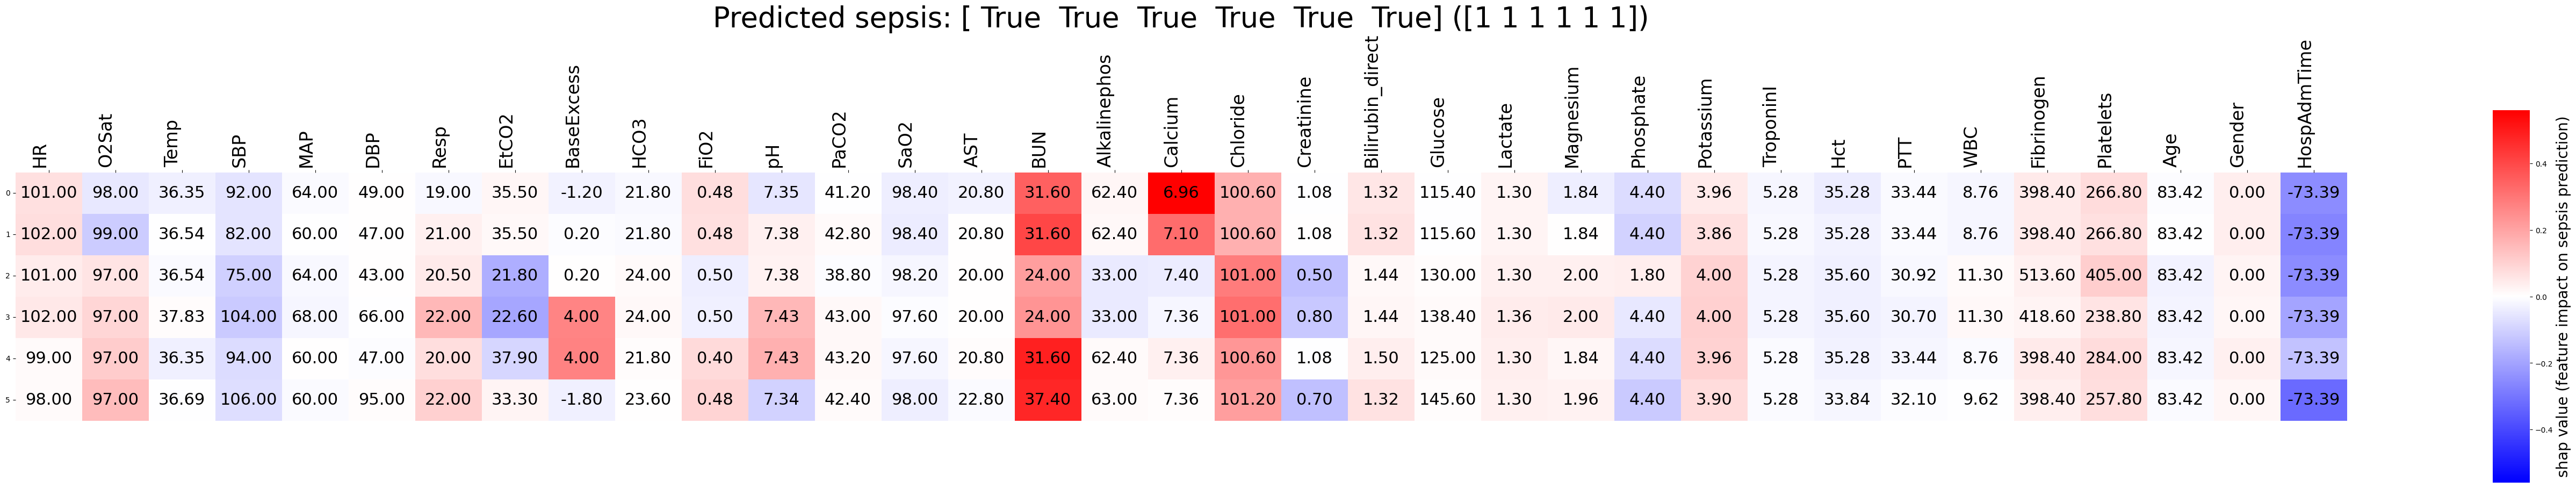

CNN: Patient 27, sepsis label: False


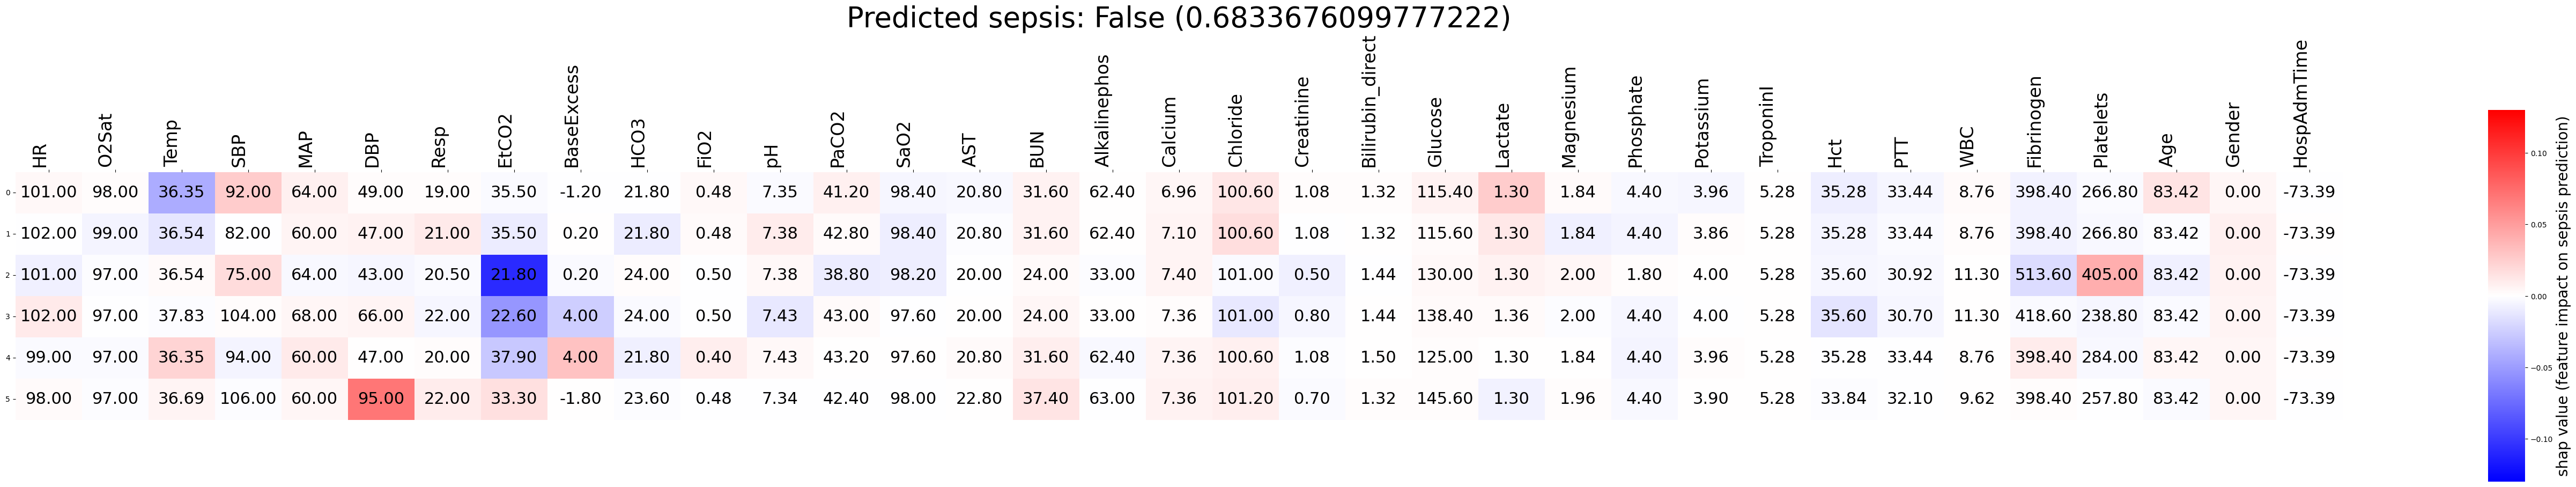

In [41]:
i=27
lstm_threshold = 0.7
print(f"LSTM: Patient {i}, sepsis label:", bool(labels_test[i]))
# print("sepsis predicted:", predictions[i] >= threshold, f'({predictions[i]:.4f})')
data_array = lstm_shap_values_all[i]
text_array = original_sequences[i]
draw_patient_pred(data_array, text_array, lstm_predictions[i], auto_scale=True, threshold=lstm_threshold)


xgb_threshold = 0.7
patient=5 # = 27 for other notebooks apparently
start=6*patient
end=6*patient+6
print(f"XGBoost: Patient {patient}, lines {start} to {end-1}, sepsis labels:", trueLabels[start:end])
# print("sepsis predicted:", predictions[i] >= threshold, f'({predictions[i]:.4f})')
data_array = xgb_shap_values_all[12:18]
text_array = X_test_arr[start:end]
draw_patient_pred(data_array, text_array, xgb_predictions[start:end], auto_scale=True, threshold=xgb_threshold)


print(f"CNN: Patient {i}, sepsis label:", bool(labels_test[i]))
# print("sepsis predicted:", predictions[i] >= threshold, f'({predictions[i]:.4f})')
data_array = cnn_shap_values_all[i]
text_array = original_sequences[i]
draw_patient_pred(data_array, text_array, cnn_predictions[i], auto_scale=False)

In [15]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 128)         │        83,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,825 (554.00 KB)

 Trainable params: 141,825 (554.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Show weights of the last layer
lstm_model.layers[-1].get_weights()

[array([[-0.05149468],
        [-0.05642574],
        [-0.16737366],
        [-0.17566407],
        [-0.18354154],
        [-0.150493  ],
        [ 0.10677963],
        [-0.11789359],
        [ 0.1326359 ],
        [-0.1740723 ],
        [-0.07495432],
        [ 0.15199342],
        [-0.04667692],
        [-0.19815111],
        [ 0.06760272],
        [ 0.09424488],
        [ 0.19670041],
        [-0.08738047],
        [-0.11050788],
        [-0.16276656],
        [-0.16421425],
        [ 0.1827377 ],
        [ 0.0447838 ],
        [-0.2278885 ],
        [-0.04588163],
        [-0.11962878],
        [-0.12911212],
        [ 0.11662339],
        [ 0.18413743],
        [ 0.06581922],
        [-0.17575175],
        [ 0.21386725],
        [ 0.194614  ],
        [ 0.14060414],
        [ 0.08087853],
        [-0.17607985],
        [-0.24217474],
        [ 0.15947084],
        [ 0.17664249],
        [ 0.19126853],
        [ 0.2198281 ],
        [-0.20629826],
        [ 0.2459606 ],
        [ 0

In [17]:
from pytorch_grad_cam import GradCAM